# Sensitivity Analysis for RL Control Policies

### Imports

In [29]:
# imports
import os
import torch

# local imports
from utils import (
    rollout2trajectory,
    subsample,
    compute_state_statistics,
    compute_dense_samples,
    compute_eigenbasis_samples,
    compute_jacobian,
    compute_hessian,
    compute_sensitivity,
    compute_multistep_sensitivity,
    compute_batch_multistep_sensitivity,
    compute_perturbation_error,
    compute_batch_perturbation_error,
    compute_projection_distances,
    compute_linearization,
    plot_matrix,
    plot_heatmap,
    plot_1d,
    plot_2d,
    plot_multistep_sensitivity,
    plot_perturbation_error,
    plot_projection_distances,
)

In [30]:
# load policy
export_dir = "../artifacts/point_mass/2025-11-27_12-15-37"
policy_path = os.path.join(export_dir, "policy_jit.pt")
critic_path = os.path.join(export_dir, "critic_jit.pt")
rollout_path = os.path.join(export_dir, "rollout.pt")
limits_path = os.path.join(export_dir, "policy_limits.pt")
io_path = os.path.join(export_dir, "policy_io.txt")
policy = torch.jit.load(policy_path).eval()
critic = torch.jit.load(critic_path).eval()
rollout = torch.load(rollout_path)
# limits = torch.load(limits_path, map_location=torch.device("cpu"))
with open(io_path, "r") as f:
    print(f.read())
data = rollout2trajectory(rollout)
rollout_obs, rollout_actions, rollout_dones, rollout_critic_obs, rollout_values = data
print(f"Rollout Data: {rollout_obs.numpy().shape}")

<ActionManager> contains 1 active terms.
+----------------------------------+
|  Active Action Terms (shape: 2)  |
+-------+--------------+-----------+
| Index | Name         | Dimension |
+-------+--------------+-----------+
|   0   | joint_effort |         2 |
+-------+--------------+-----------+

<ObservationManager> contains 1 groups.
+---------------------------------------------------+
| Active Observation Terms in Group: 'policy' (shape: (4,)) |
+--------------+---------------------+--------------+
|    Index     | Name                |    Shape     |
+--------------+---------------------+--------------+
|      0       | pose                |     (2,)     |
|      1       | velocity            |     (2,)     |
+--------------+---------------------+--------------+

Rollout Data: (100, 8192, 4)


### Sensitivity Matrix

#### Jacobian

Let $J(x)=\nabla_x \bar u(x) \in \mathbb{R}^{|x|\times|u|}$ be the gradient of the mean control action with respect to the observation with $\bar u(x) = \mathbb{E}\left [\pi(u|x) \right ]$. This Jacobian represents how much the control action changes given a change in the observed state.

#### Local Sensitivity
$$C(x) = J(x)^T J(x)\in \mathbb{R}^{|x|\times|x|}$$

#### Global Approximation of Sensitivity
$$\hat C = \mathbb{E}_{x\sim p_\tau}\left [ J(x)^T J(x) \right ]$$

Let $x_0 \sim \rho(x_0)$ be a uniform prior. Then the marginal visitation distribution induced by $\rho(x_0)$ is given by 

$$p(x_t) = \rho(x_0)\prod^{t-1}_{k=0}T(x_{k+1}|x_k,u_k)\pi(u_k|x_k)$$

with stochastic state transition density $T$ and controller $\pi$. We define the liklihood over the trajectory as 

$$p_\tau(x_0,...,x_t) := \int_{k=0}^{t} p(x_k)dx_k.$$

In practice, we do not have an analytic form for the state transition density and so perform Monte Carlo sampling. Given $N$ rollouts over horizon length $T$ we collect trajectories $\tau=\{(x_0,u_0),(x_1,u_1),...,(x_T,u_T) \}$ with control actions sampled as $u_k\sim\pi(u_k|x_k)$. We then form an approximate state distribution such that $|X_\text{rollout}| = T * N$.

Expanding the expected value yields

$$\hat C = \int_{X_\text{rollout}} p_\tau(x) J(x)^T J(x) dx \approx \frac{1}{|X_\text{rollout}|}\sum_{X_\text{rollout}} J(x)^T J(x)$$

approximated via Monte Carlo. Practically, to prevent overflow for very large samples sizes, the sensitivity can be found iteratively via partial sums for $k=\{0,1,...,|X_\text{rollout}|\}$

$$C(x_k) = J(x_k)^TJ(x_k) \qquad \hat C_0 = C(x_0)$$
$$\hat C_{k+1} = \hat C_k + \frac{1}{k+1}(C(x_{k+1}) - \hat C_k)$$

#### Spectral Analysis

The eigenvalues and eigenvectors of the sensitivity matrix are given by

$$Cv=\lambda v.$$

The direction of worst-case sensitivity is given by the eigenvector $v$ corresponding to the largest eigenvalue $\lambda_\text{max}$.



analysis:
- does history length get used? for double integrator, dont use velocity, only position. rewards for poseition, vel, accel and every sub combo with different history lengths
- quantify symmetry
- quantify sim2real? function of sensitivity (train with and without DR for a given obs and see difference in sensitivity)
- design vs. deployment issues (eg cant change observation space at runtime)
- global eigvec (worst case direction) vs local
- project current state onto global eigvecs / local eigvecs to measure how close to sensitive region
- gradient penalty to enforce symmetric sensitivity? (eg left/right for the same joint)

### Synthetic

In [31]:
n_grid = 100
states_uniform, x, y = compute_dense_samples(rollout_obs, n_grid, mode="point_mass")
# Compute sensitivity for eigenbasis
C_critic_uniform, _, eigvecs_critic_uniform, _, _ = compute_sensitivity(critic, states_uniform)

states_uniform_eig, a, b = compute_eigenbasis_samples(eigvecs_critic_uniform, n_grid)
with torch.no_grad():
    values = critic(states_uniform).flatten()
    values_eig = critic(states_uniform_eig).flatten()

# multi step
eigvals_policy_uniform_traj, eigvecs_policy_uniform_traj = compute_multistep_sensitivity(policy, states_uniform)[1:3]
eigvals_critic_uniform_traj, eigvecs_critic_uniform_traj = compute_multistep_sensitivity(critic, states_uniform)[1:3]

# eigvals_policy_uniform_traj_eig = compute_multistep_sensitivity(policy, states_uniform_eig)[1]
# eigvals_critic_uniform_traj_eig = compute_multistep_sensitivity(critic, states_uniform_eig)[1]

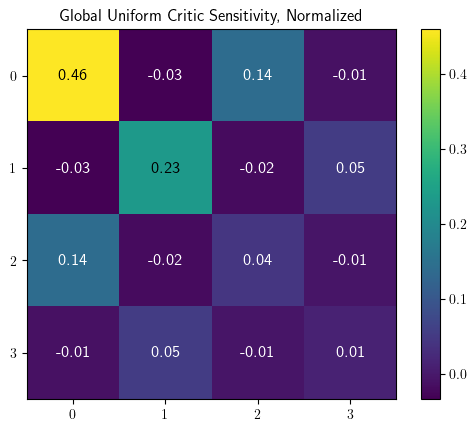

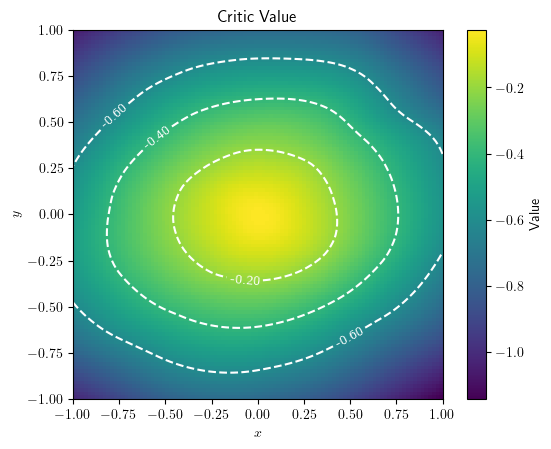

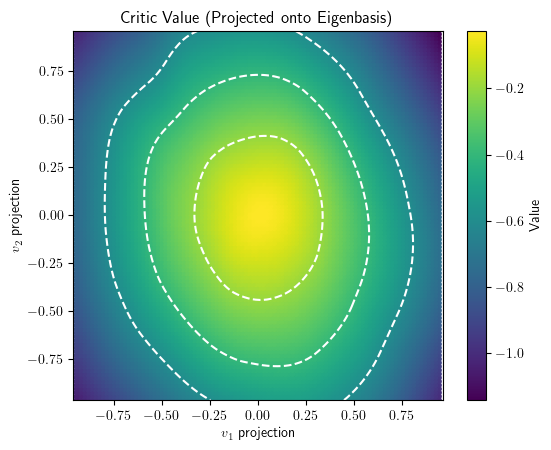

In [32]:
# Critic heatmap
level_sets = [-0.6, -0.4, -0.2]

# Plot 1: Critic Sensitivity Matrix
plot_matrix(C_critic_uniform, "Global Uniform Critic Sensitivity", normalize=True)

# Plot 2: (x, y) heatmap
plot_heatmap(x, y, values, r"Critic Value", r"$x$", r"$y$", "Value", level_sets)


# Plot 3: eigenbasis sampling heatmap
# plot_heatmap(a, b, values_eig, r"Critic Value Heatmap (Eigenbasis Sampling)", r"$v_1$", r"$v_2$", "Value", level_sets)

# Plot 4: projected states onto eigenbasis
proj = compute_projection_distances(states_uniform, eigvecs_critic_uniform, mean_center=True)
plot_heatmap(proj[:, 0], proj[:, 1], values, r"Critic Value (Projected onto Eigenbasis)", r"$v_1$ projection", r"$v_2$ projection", "Value", level_sets, use_scatter=True)

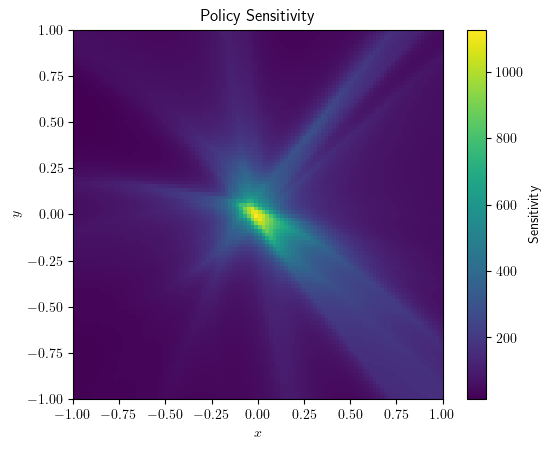

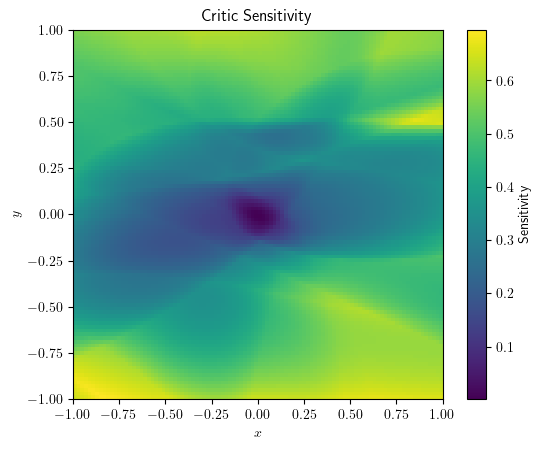

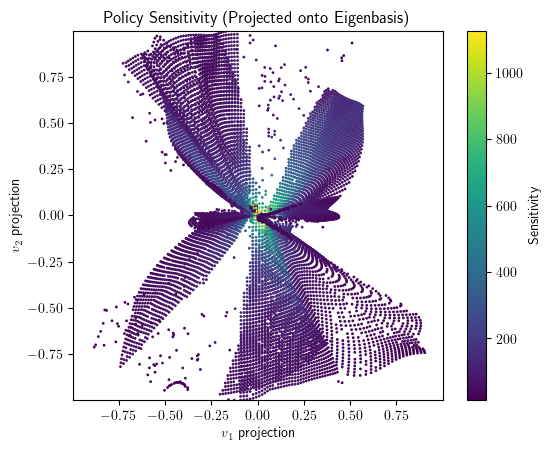

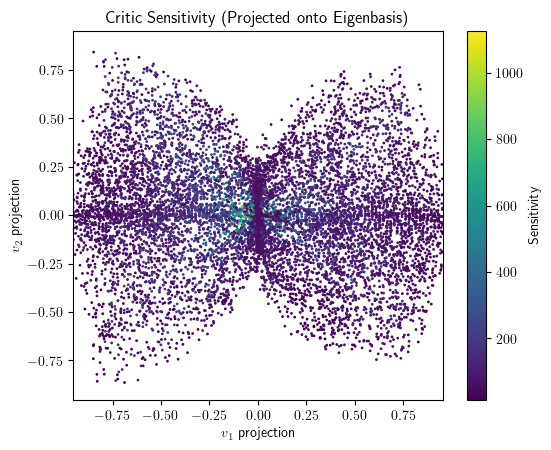

In [33]:
# Sensitivity heatmap
sensitivity_policy = eigvals_policy_uniform_traj.norm(dim=1)
sensitivity_critic = eigvals_critic_uniform_traj.norm(dim=1)
# sensitivity_policy_eig = eigvals_policy_uniform_traj_eig.norm(dim=1)
# sensitivity_critic_eig = eigvals_critic_uniform_traj_eig.norm(dim=1)

proj_policy = compute_projection_distances(states_uniform, eigvecs_policy_uniform_traj, mean_center=True)
proj_critic = compute_projection_distances(states_uniform, eigvecs_critic_uniform_traj, mean_center=True)

plot_heatmap(x, y, sensitivity_policy, r"Policy Sensitivity", r"$x$", r"$y$", "Sensitivity", level_sets=None)
plot_heatmap(x, y, sensitivity_critic, r"Critic Sensitivity", r"$x$", r"$y$", "Sensitivity", level_sets=None)

# plot_heatmap(a, b, sensitivity_policy_eig, r"Policy Sensitivity (Eigenbasis Sampling)", r"$v_1$", r"$v_2$", "Sensitivity", level_sets=None, use_scatter=True, size=10)
# plot_heatmap(a, b, sensitivity_critic_eig, r"Critic Sensitivity (Eigenbasis Sampling)", r"$v_1$", r"$v_2$", "Sensitivity", level_sets=None, use_scatter=True, size=10)

plot_heatmap(proj_policy[:, 0], proj_policy[:, 1], sensitivity_policy, r"Policy Sensitivity (Projected onto Eigenbasis)", r"$v_1$ projection", r"$v_2$ projection", "Sensitivity", level_sets=None, use_scatter=True, size=1)
plot_heatmap(proj_critic[:, 0], proj_critic[:, 1], sensitivity_policy, r"Critic Sensitivity (Projected onto Eigenbasis)", r"$v_1$ projection", r"$v_2$ projection", "Sensitivity", level_sets=None, use_scatter=True, size=1)

### Real

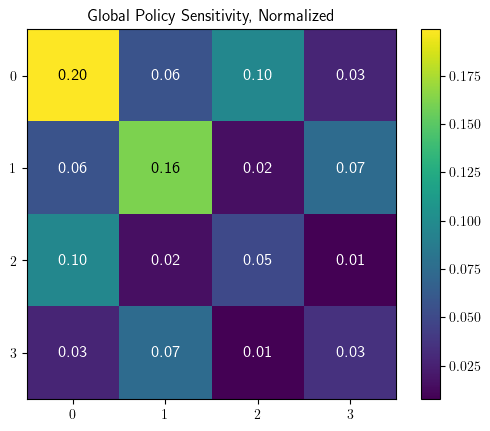

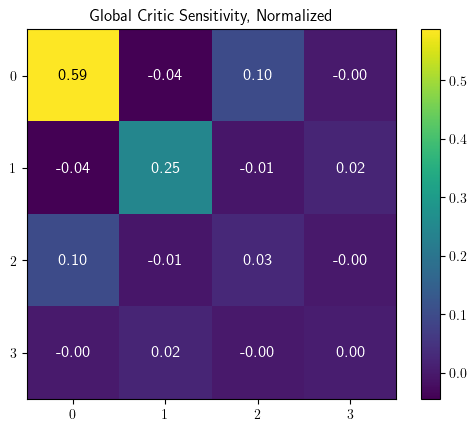

In [43]:
# sensitivity matrix
states = rollout_obs
states_flat = states.reshape(-1, 4)
# compute_state_statistics(states_flat)
C_global, eigvals_global, eigvecs_global, explained_energy_global, input_activity_global = compute_sensitivity(policy, states_flat)
plot_matrix(C_global, "Global Policy Sensitivity", normalize=True)
C_global_critic, _, _, _, _ = compute_sensitivity(critic, states_flat)
plot_matrix(C_global_critic, "Global Critic Sensitivity", normalize=True)

C_traj, eigvals_traj, eigvecs_traj = compute_multistep_sensitivity(policy, states[:, 0])[0:3]

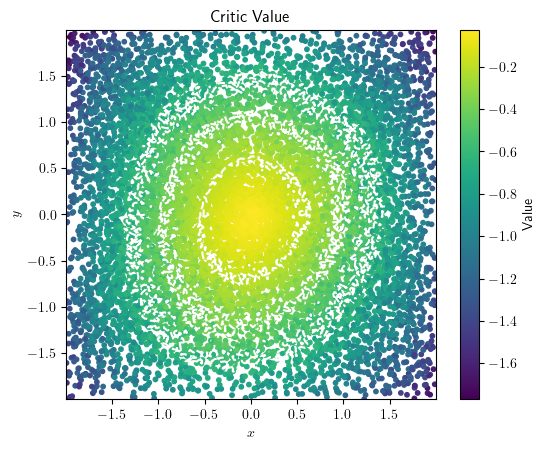

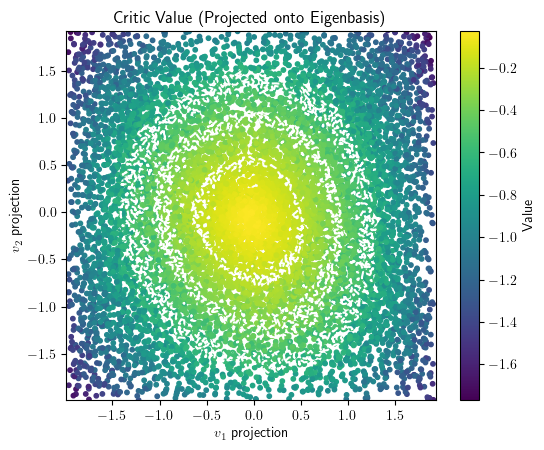

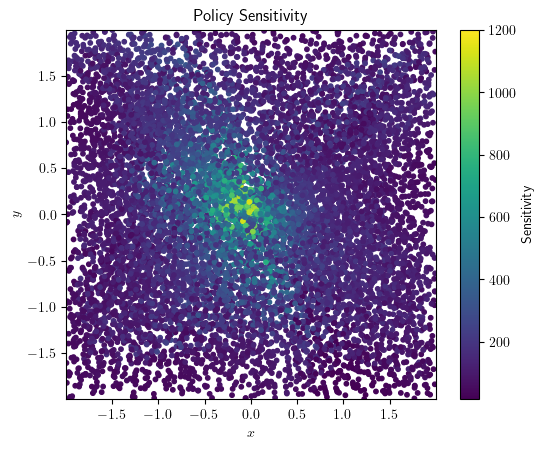

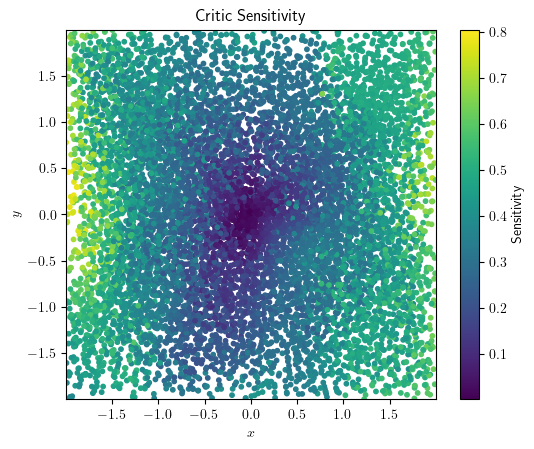

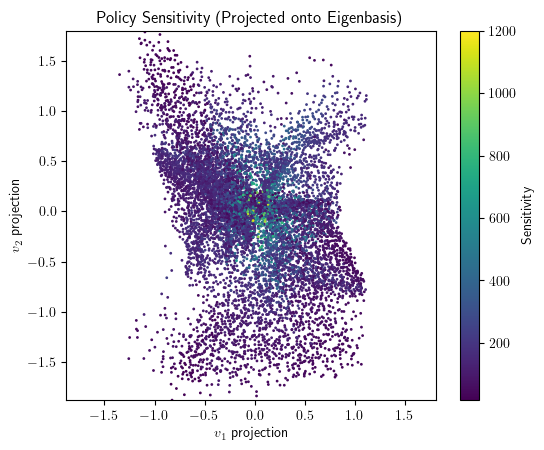

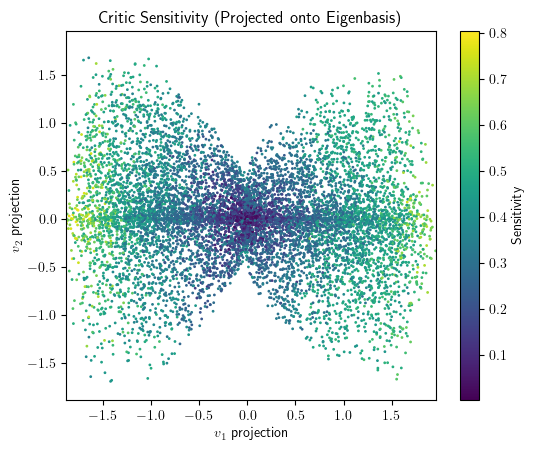

In [35]:
# Heatmaps using real rollout data
states_rollout_full = rollout_obs.reshape(-1, 4)

# Subsampling parameters
n_plot_samples = 10_000  # Number of samples for plotting
subsample_method = "farthest_point"  # "random" or "farthest_point"
min_dist = None  # Alternative: use minimum distance for farthest_point

# Subsample states once upfront
(states_rollout,) = subsample(states_rollout_full, method=subsample_method, n_samples=n_plot_samples, device="cpu")
x_rollout = states_rollout[:, 0]
y_rollout = states_rollout[:, 1]

# Compute sensitivity for eigenbasis on subsampled data
C_critic_rollout, _, eigvecs_critic_rollout, _, _ = compute_sensitivity(critic, states_rollout)

with torch.no_grad():
    values_rollout = critic(states_rollout).flatten()

# Multi-step sensitivity on subsampled data
eigvals_policy_rollout_traj, eigvecs_policy_rollout_traj = compute_multistep_sensitivity(policy, states_rollout)[1:3]
eigvals_critic_rollout_traj, eigvecs_critic_rollout_traj = compute_multistep_sensitivity(critic, states_rollout)[1:3]

sensitivity_policy_rollout = eigvals_policy_rollout_traj.norm(dim=1)
sensitivity_critic_rollout = eigvals_critic_rollout_traj.norm(dim=1)

proj_rollout = compute_projection_distances(states_rollout, eigvecs_critic_rollout, mean_center=True)
proj_policy_rollout = compute_projection_distances(states_rollout, eigvecs_policy_rollout_traj, mean_center=True)
proj_critic_rollout = compute_projection_distances(states_rollout, eigvecs_critic_rollout_traj, mean_center=True)

# Plotting
level_sets_rollout = [-0.6, -0.4, -0.2]

# (x, y) heatmap
plot_heatmap(x_rollout, y_rollout, values_rollout, r"Critic Value", r"$x$", r"$y$", "Value", level_sets_rollout, use_scatter=True, size=10)

# Projected states onto eigenbasis
plot_heatmap(proj_rollout[:, 0], proj_rollout[:, 1], values_rollout, r"Critic Value (Projected onto Eigenbasis)", r"$v_1$ projection", r"$v_2$ projection", "Value", level_sets_rollout, use_scatter=True, size=10)

# Sensitivity heatmaps
plot_heatmap(x_rollout, y_rollout, sensitivity_policy_rollout, r"Policy Sensitivity", r"$x$", r"$y$", "Sensitivity", level_sets=None, use_scatter=True, size=10)
plot_heatmap(x_rollout, y_rollout, sensitivity_critic_rollout, r"Critic Sensitivity", r"$x$", r"$y$", "Sensitivity", level_sets=None, use_scatter=True, size=10)

plot_heatmap(proj_policy_rollout[:, 0], proj_policy_rollout[:, 1], sensitivity_policy_rollout, r"Policy Sensitivity (Projected onto Eigenbasis)", r"$v_1$ projection", r"$v_2$ projection", "Sensitivity", level_sets=None, use_scatter=True, size=1)
plot_heatmap(proj_critic_rollout[:, 0], proj_critic_rollout[:, 1], sensitivity_critic_rollout, r"Critic Sensitivity (Projected onto Eigenbasis)", r"$v_1$ projection", r"$v_2$ projection", "Sensitivity", level_sets=None, use_scatter=True, size=1)

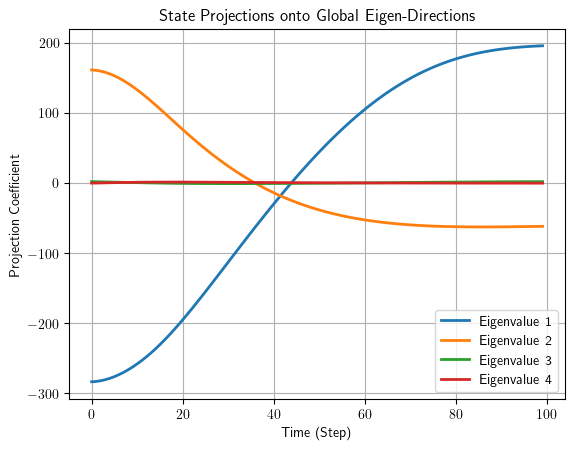

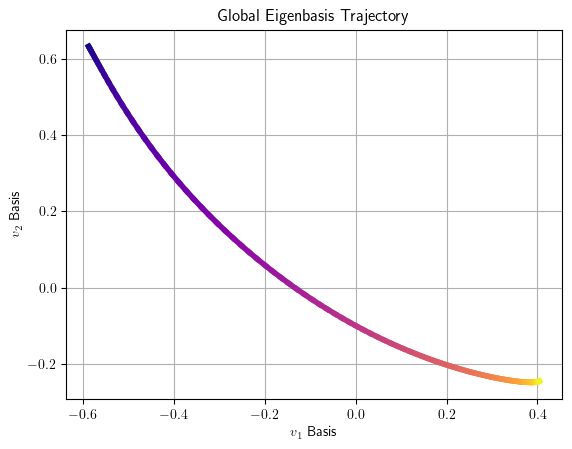

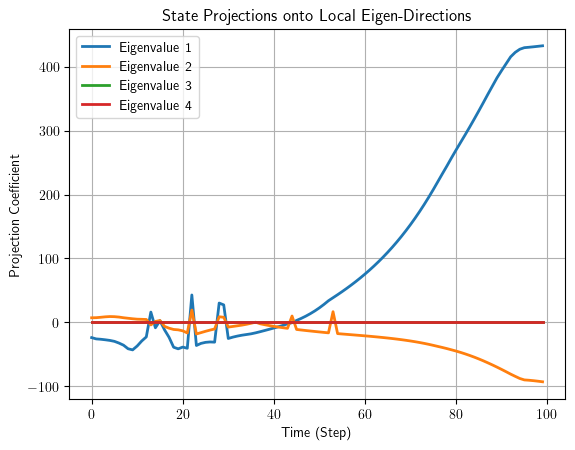

In [50]:
proj_dist_global_dir = compute_projection_distances(states[:, 0], eigvecs_global, mean_center=True)
plot_1d(proj_dist_global_dir * eigvals_global, f"State Projections onto Global Eigen-Directions", "Time (Step)", "Projection Coefficient", prefix="Eigenvalue ")
plot_2d(proj_dist_global_dir, "Global Eigenbasis Trajectory", r"$v_1$ Basis", r"$v_2$ Basis", temporal=True, linewidth=4)
# proj_dist_all = compute_projection_distances(states_flat, eigvecs_global, mean_center=True)
# plot_2d(proj_dist_all, "Global Eigenbasis Trajectory", r"$v_1$ Basis", r"$v_2$ Basis", temporal=True, linewidth=4)
proj_dist_local = compute_projection_distances(states[:, 0], eigvecs_traj, mean_center=True)
plot_1d(proj_dist_local * eigvals_traj, f"State Projections onto Local Eigen-Directions", "Time (Step)", "Projection Coefficient", prefix="Eigenvalue ")

### Spectral Analysis
$$Cv=\lambda v$$

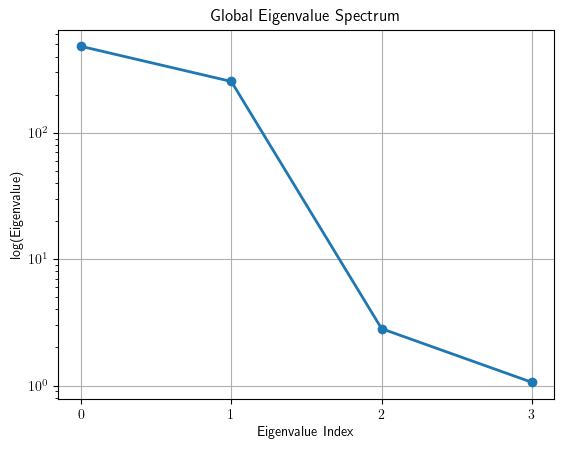

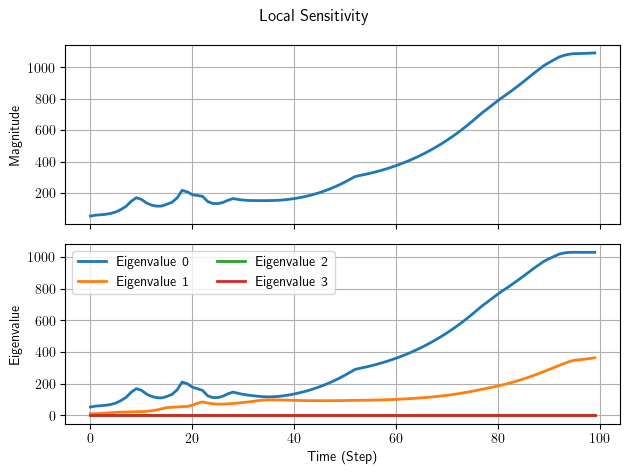

In [46]:
plot_1d(eigvals_global, "Global Eigenvalue Spectrum", "Eigenvalue Index", "log(Eigenvalue)", logy=True, xticks=True, marker="o")
out = compute_batch_multistep_sensitivity(policy, rollout_obs[:, [0]])
C_batch, eigvals_batch, eigvecs_batch, explained_energy_batch, input_activity_batch = out
plot_multistep_sensitivity(C_batch, eigvals_batch, log=False)

### Explained Energy
$$E_i=\frac{\sum_j^i\lambda_j}{\sum\lambda}$$

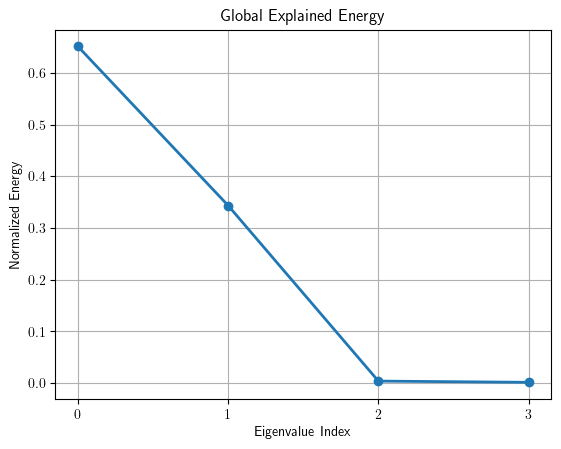

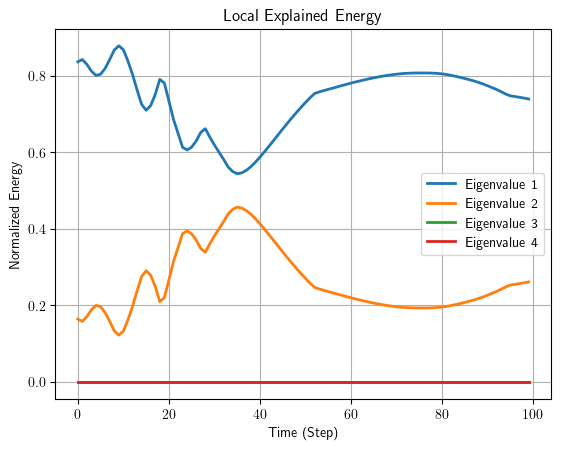

In [47]:
plot_1d(explained_energy_global, "Global Explained Energy", "Eigenvalue Index", "Normalized Energy", marker="o", xticks=True)
plot_1d(explained_energy_batch.squeeze(dim=1), "Local Explained Energy", "Time (Step)", "Normalized Energy", prefix="Eigenvalue ")

### Active Subspace
$$\alpha_i=\sum_j\lambda_jv_{ji}^2$$

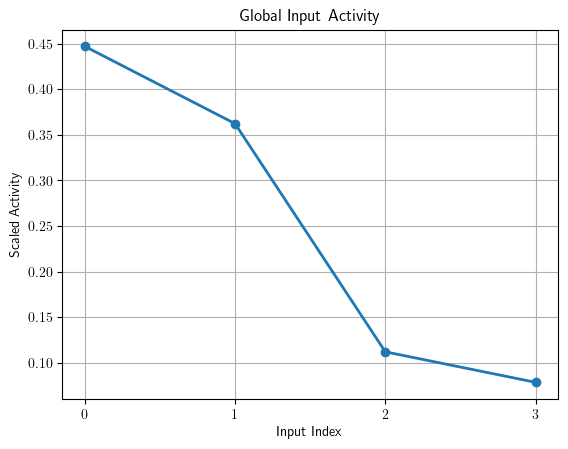

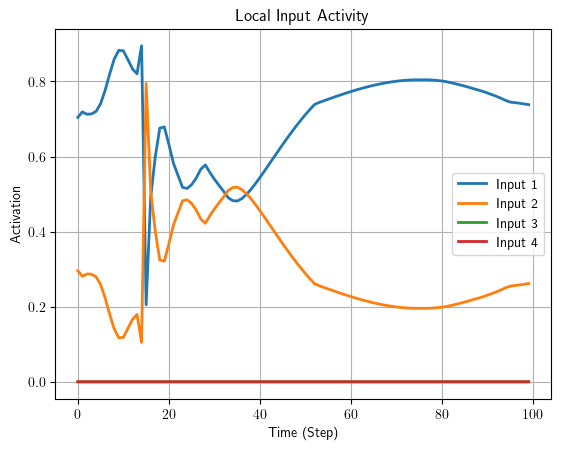

In [48]:
plot_1d(input_activity_global, "Global Input Activity", "Input Index", "Scaled Activity", marker="o", xticks=True)
plot_1d(input_activity_batch.squeeze(dim=1), "Local Input Activity", "Time (Step)", "Activation", prefix="Input ")

### Sensitivity to Perturbation
$$\max_{v}||\pi(x+\alpha v) - \pi(x)|| \approx \alpha||J(x) v||$$

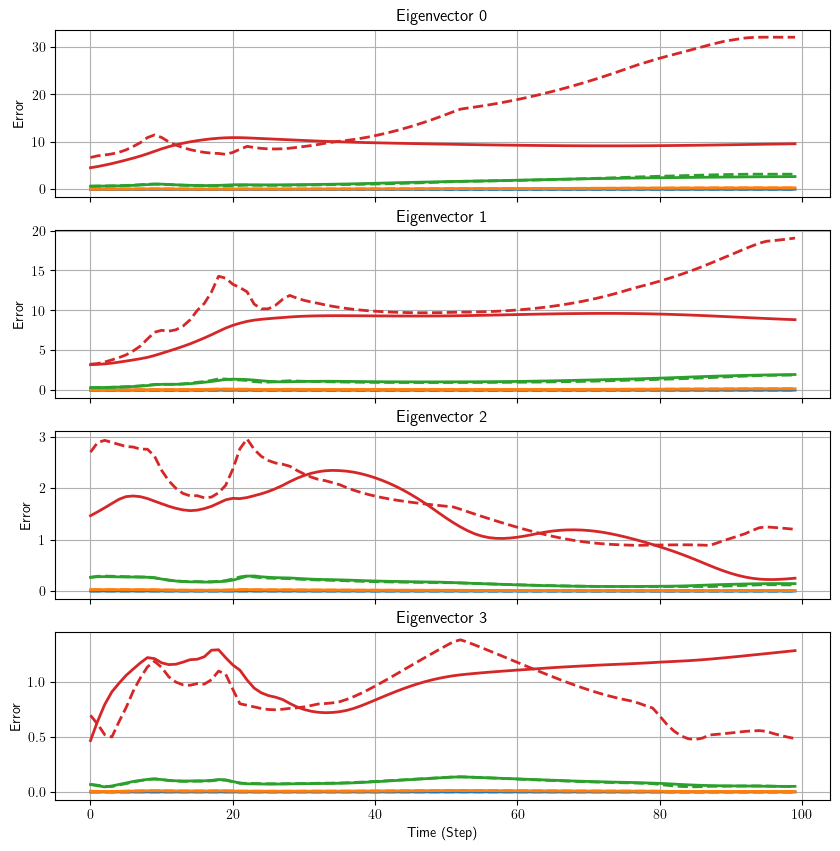

In [49]:
radii = [0.001, 0.01, 0.1, 1.0]
errors, errors_linear = compute_perturbation_error(policy, rollout_obs, eigvecs_global, radii, env_idx=0)
plot_perturbation_error(errors, errors_linear, eigvecs_global, radii, log=False)

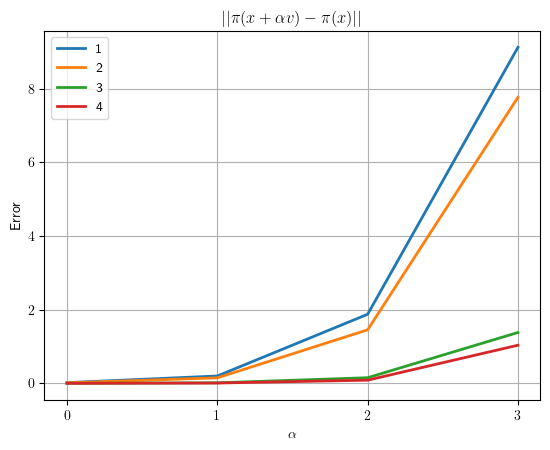

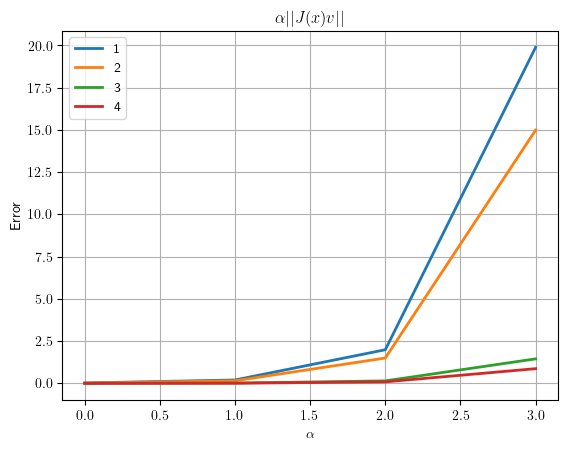

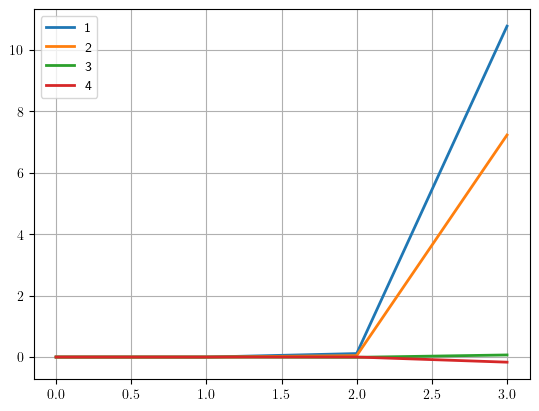

In [41]:
errors, errors_linear = compute_batch_perturbation_error(policy, rollout_obs, eigvecs_global, radii)
plot_1d(errors.T, r"$||\pi(x+\alpha v) - \pi(x)||$", r"$\alpha$", "Error", xticks=True, logx=False)
plot_1d(errors_linear.T, r"$\alpha||J(x)v||$", r"$\alpha$", "Error")
plot_1d(errors_linear.T - errors.T, "", "", "")